# Ch8: Lab 1- Classification Trees

- [Import Carseats Data](#Import-Carseats-Data)
- [Create Classification Tree](#Create-Classification-Tree)
- [Compute Training Error Rate](#Compute-Training-Error-Rate)
- [Split Data](#Split-Data)
- [Compute Test Error Rate](#Compute-Test-Error-Rate)
- [Notes about Pruning](#Notes-about-Pruning)

# Anaconda Prompt 에서


### conda install -c conda-forge python-graphviz 



In [3]:
import numpy as np
import pandas as pd
import graphviz


from sklearn.tree import tree, export_graphviz
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import Image, display
%matplotlib inline
plt.style.use('ggplot')

## Import Carseats Data

In [4]:
# read in csv of data
df = pd.read_csv('data/Carseats.csv')
# create a new column called High, a boolean for if sales > 8
df['High'] = df.Sales > 8
df = pd.get_dummies(df, columns=['ShelveLoc', 'Urban', 'US'])
# drop the unnecessary columns -- remember the number of dummies is always one less than the number of levels
df = df.drop(['ShelveLoc_Bad', 'Urban_No', 'US_No'],axis=1)
df.head()


,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,High,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,True,0,0,1,1
1,11.22,111,48,16,260,83,65,10,True,1,0,1,1
2,10.06,113,35,10,269,80,59,12,True,0,1,1,1
3,7.40,117,100,4,466,97,55,14,False,0,1,1,1
4,4.15,141,64,3,340,128,38,13,False,0,0,1,0


## Create Classification Tree

In [5]:
clf = tree.DecisionTreeClassifier(min_samples_split=20)

# get the predictors
feature_cols = list(df)
print(feature_cols)

feature_cols.remove('Sales')
feature_cols.remove('High')
X = df[feature_cols]

# get the response
y = df.High

# Build classification tree
clf = tree.DecisionTreeClassifier(min_samples_split=20)
print(clf)
tree_est = clf.fit(X, y)

['Sales', 'CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age', 'Education', 'High', 'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_Yes', 'US_Yes']
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


In [6]:
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='seat_tree.dot',feature_names=feature_cols, 
                class_names=['True', 'False'],filled=True, rounded=True,  
                        special_characters=True)

In [7]:
with open('seat_tree.dot') as f:
    dot_graph = f.read()  

In [8]:
# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')

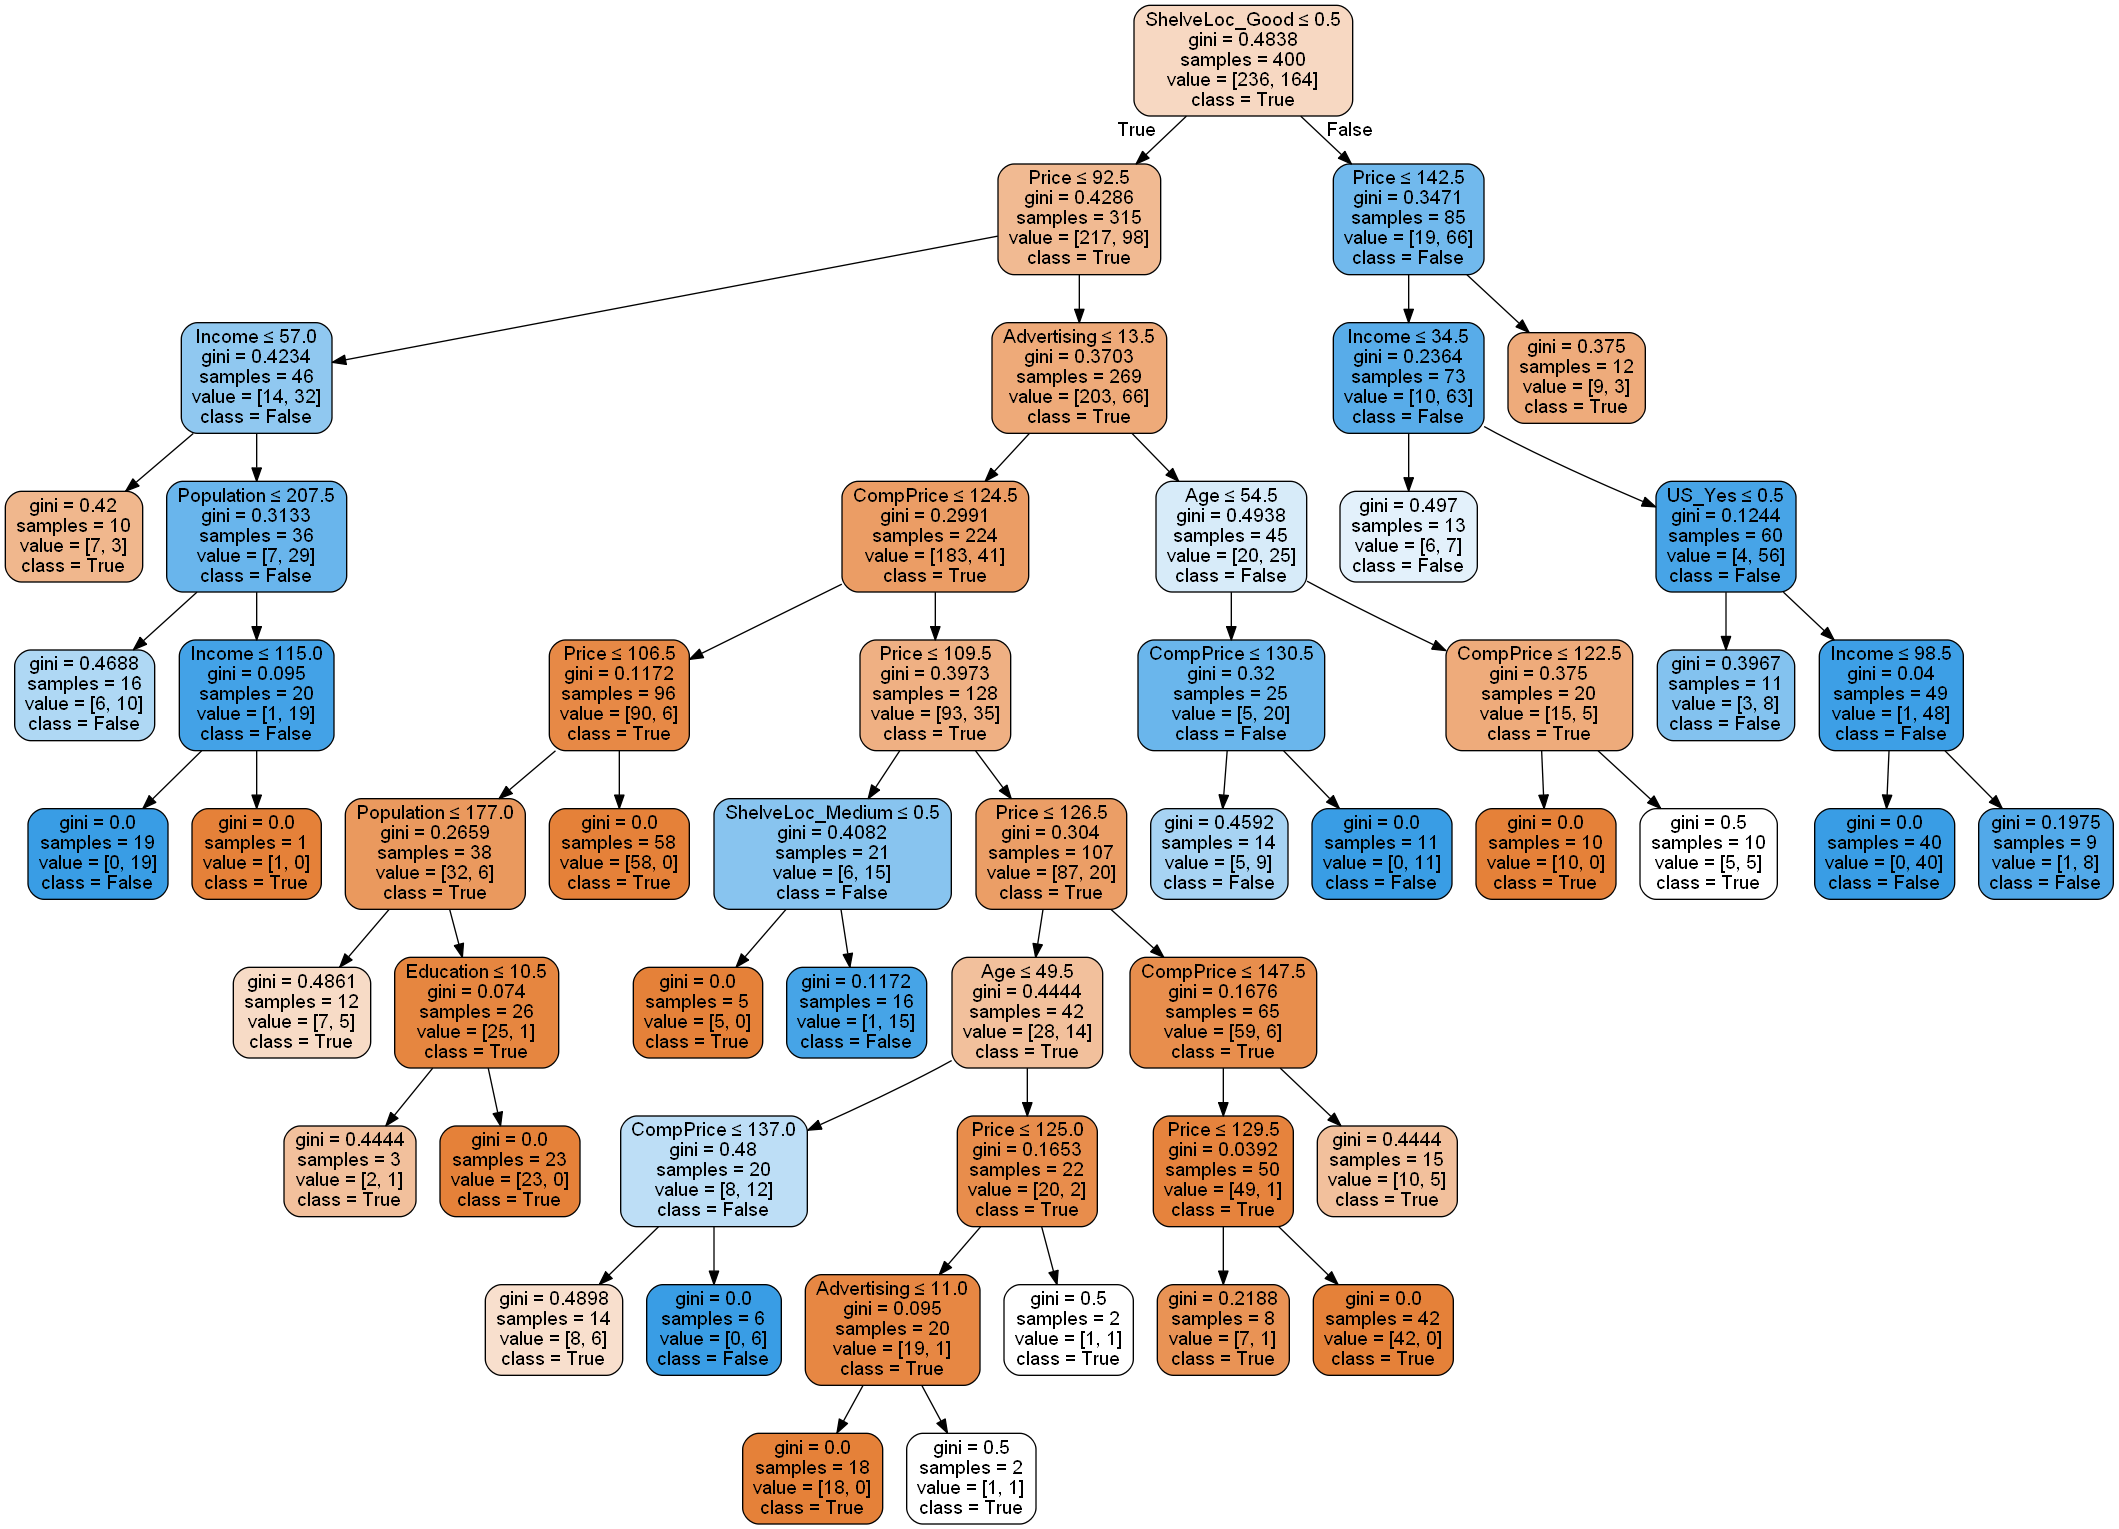

In [9]:
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

In [10]:
# also show the view of the source object in browser so we can zoom in on nodes and see what we've got
I.view()

'Source.gv.png'

So we see that the initial splitting occurs with ShelveLoc and Price predictors. We can get the variable importance factor (the average Gini Index) for a predictor from sklearn.

In [11]:
feature_importances = tree_est.feature_importances_
pd.DataFrame(data=feature_importances, index=feature_cols, columns = ['Importance']).sort_values(by=['Importance'], 
                                                                                                ascending=False)

,Importance
Price,0.303185
ShelveLoc_Good,0.228331
CompPrice,0.109957
Age,0.095710
Advertising,0.088996
Income,0.074141
ShelveLoc_Medium,0.052739
Population,0.033288
US_Yes,0.009009
Education,0.004645


## Compute Training Error Rate

In [12]:
# Lets also get the training error rate of the tree model
cmatrix = confusion_matrix(y_true = y, y_pred=tree_est.predict(X), labels=[True, False])
print(cmatrix)

[[133  31]
 [ 22 214]]


In [13]:
error_rate = (cmatrix[0,1]+cmatrix[1,0])/cmatrix.sum()
print("Training Error Rate:", error_rate)

Training Error Rate: 0.1325


## Split Data

In [14]:
# make a split using 67% of the data for training and the remainder for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

## Compute Test Error Rate

In [15]:
# Train the model
tree_est = clf.fit(X_train, y_train)
# make predictions 
ypred = tree_est.predict(X_test)

cmatrix_test = confusion_matrix(y_true = y_test, y_pred=ypred, labels=[True, False])
error_rate = (cmatrix_test[0,1]+cmatrix_test[1,0])/cmatrix_test.sum()
print("Test Error Rate:", error_rate)

Test Error Rate: 0.333333333333


In [18]:
#from sklearn import grid_search
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.682835820896 {'max_depth': 8}


These error rates are within a few percent of the labs values. Remember they may be using a different splitting criteria (above I stopped splitting when 20 samples were left) and the train test splits will not be the same.

In [19]:
# Build classification tree
clf = tree.DecisionTreeClassifier(min_samples_split=20, max_depth=8)
# Train the model
tree_est = clf.fit(X_train, y_train)
# make predictions 
ypred = tree_est.predict(X_test)

cmatrix_test = confusion_matrix(y_true = y_test, y_pred=ypred, labels=[True, False])
error_rate = (cmatrix_test[0,1]+cmatrix_test[1,0])/cmatrix_test.sum()
print("Test Error Rate:", error_rate)

Test Error Rate: 0.325757575758


## Notes about Pruning

Pruning for a classification Tree involves selecting a set of subtrees as a function of a penalization factor $\alpha $ according to the equation $\sum_{m=1}^{|T|}\sum_{i: x_i \in R_m}(y_i-\hat{y})^2+\alpha|T|$ and then using CV to find the optimal subtree. Sklearn does not provide any methods in their tree class to accomplish pruning. To implement this, we would need to develop a way to prune the returned tree object from sklearn. Since, pruned trees are not as competitive, in terms of predictive accuracy, with other models we will move on. I hope to come back to this and add this functionality to sklearn. It appears to be the first time in the ISLR book that we have hit a method where statsmodels or sklearn can not accomplish the same task as R.